In [1]:
import geopandas as gpd
from shapely import Point
import matplotlib.pyplot as plt
plt.rcParams['font.family']=['monospace']

In [2]:
url = 'https://www.ordnancesurvey.co.uk/legacy/docs/gps/CompleteTrigArchive.zip'
trigpoints = gpd.read_file(url)

for var in ['EASTING','NORTHING','HEIGHT']:
    trigpoints[var] = trigpoints[var].astype('float32')
    
trigpoints['geometry'] = trigpoints.apply(lambda q: Point(q['EASTING'],
                                                          q['NORTHING']),
                                          axis=1)
trigpoints = trigpoints.set_crs(27700)

In [ ]:
fig, ax = plt.subplots(figsize=[10,10])

trigpoints.loc[(trigpoints['DESTROYED MARK INDICATOR']=='0')
               &
               (trigpoints['TYPE OF MARK'] == 'PILLAR')].plot(ax=ax,
                                                              markersize=0.1,
                                                              column='HEIGHT',
                                                              cmap='gist_earth',
                                                              legend=True,
                                                              legend_kwds={
                                                                  'label':'Elevation (m)',
                                                                  'shrink':0.9,
                                                                  }
                                                              )
_ = ax.set_title('Trig Points of\nGreat Britain',
                 loc='left',
                 y=0.95,
                 fontsize=16,
                 )

ax.set_axis_off()

# fig.savefig('day1.png', bbox_inches='tight')

### extension: joining trig points to nearest *k* neighbours

In [8]:
from scipy.spatial import distance
import numpy as np
import pandas as pd
from shapely import LineString, MultiLineString

In [51]:
## filter list of trig points
tp = trigpoints.loc[(trigpoints['DESTROYED MARK INDICATOR']=='0')
                    &
                    (trigpoints['TYPE OF MARK'] == 'PILLAR')].reset_index()

coords = list(zip(tp.geometry.x.tolist(), tp.geometry.y.tolist()))

# compute pair-wise distances
distances = distance.cdist(coords,coords)

# swap zeros on diagonal for nans
distances[distances==0]=np.nan
distances = pd.DataFrame(distances,
                         index=tp.index,
                         columns=tp.index)

In [52]:
# function for returning index of *k* minimum values
def idxmink(arr,k):
    idx = np.argpartition(arr.values,k)
    k_idx = idx[:k]
    return k_idx

In [53]:
# select k, apply function
k = 2
alphabet = 'abcdefghijklmnop'
letters = [i for n,i in enumerate(alphabet) if n < k]
tp['nearest_idxs'] = distances.apply(lambda q: idxmink(q,k) , axis=1)

# expand list of k indices each into their own column
tp[letters] = pd.DataFrame(tp['nearest_idxs'].tolist(), index=tp.index)

# for each index, get geometry, and create linestring
for var in letters:
    ls = [LineString(q) for q in list(zip(tp['geometry'],
                                          tp.loc[tp[var],'geometry']))]
    tp[var+'_geo'] = ls

# construct multi linestring for k-nearest and make geodataframe
tp_k_nearest = tp[[var+'_geo' for var in letters]].apply(lambda q: MultiLineString(q.tolist()),
                                                         axis=1)

k_nearest = gpd.GeoDataFrame(geometry=tp_k_nearest,crs=27700)
# that definitely contains duplicates

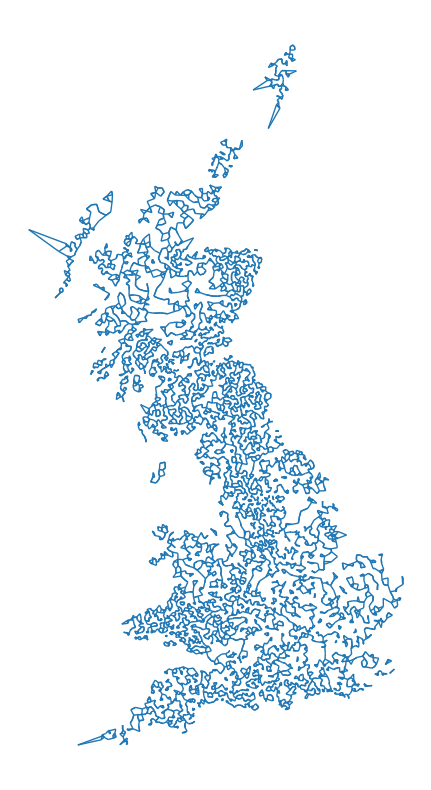

In [60]:
ax=k_nearest.plot(figsize=[10,10],
                  linewidth=1)
ax.set_axis_off()